In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))
sys.path.append(os.path.join(os.getcwd(), "iclr19-graph2graph/props"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN, fused_gw_torch
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, load_checkpoint, initialize_models
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 
from mol_opt.ot_utils import compute_barycenter

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from molgen.metrics.Penalty import Penalty as PenaltyNew

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis


In [31]:
model_type = "deepsets"
sys.argv = ["", "-model_type", model_type, "-one_batch_train"]
args = get_args()
args.n_epochs = 100 
args.init_model = "{}-attention-gcn2-sink6-test8".format(model_type)
# args.output_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/output_dev4/{}/".format(args.init_model)
args.output_dir = "/run/media/octav/data-volume/tum-thesis/output_dev4_saves/{}/".format(args.init_model)
args.tb_logs_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/logs_dev4/{}".format(args.init_model)
args.batch_size = 50 

print (args.output_dir)
print (args.tb_logs_dir)

/run/media/octav/data-volume/tum-thesis/output_dev4_saves/deepsets-attention-gcn2-sink6-test8/
/home/octav/gitrepos/tum-thesis/mol_opt/logs_dev4/deepsets-attention-gcn2-sink6-test8


In [32]:
model = args.init_model
model_iter = 6000 

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)

# molopt, molopt_decoder, _, pen, recpen, _, _, config, _ = load_checkpoint(args.output_dir + model_name ,init_fc = initialize_models, device = 'cpu')
molopt, molopt_decoder, optimizer, pen, recpenalty, crossatt, scheduler = initialize_models(args)

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False, device = 'cpu')
fgw_loss = FGW(alpha = 0.5)
# pen = PenaltyNew(config, model_iter)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)
pen.log()

/run/media/octav/data-volume/tum-thesis/output_dev4_saves/deepsets-attention-gcn2-sink6-test8/model_deepsets-attention-gcn2-sink6-test8_6000
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=200, bias=False)
    (W_message_h): Linear(in_features=200, out_features=200, bias=False)
    (W_message_o): Linear(in_features=293, out_features=150, bias=True)
    (W_mol_h): Linear(in_features=150, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (GCN2): GCN(
    (W_message_i): Linear(in_features=100, out_features=200, bias=False)
    (W_message_h): Linear(in_features=200, out_features=200, bias=False)
    (W_message_o): Linear(in_features=293, out_features=150, bias=True)
    (W_mol_h): Linear(in_features=150, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn

In [35]:
# train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)
datatype = "train"
train_data_loader = get_loader("molgen/data/chembl50", datatype, 50, same_number_atoms = True)

for i in train_data_loader:
#     X = (MolGraph(i[0]))
#     Y = (MolGraph(i[1]))
    X = MolGraph(i)
    Y = X
    break

In [36]:
x_encoding, x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
# yhat_labels = molopt_decoder.discretize_gumbel(*yhat_logits, tau = pen.tau)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

pen.mirror = ""

pen.tau = 0.05
fgw_loss_item = fgw_loss(*pred_pack, tau = 1)
print (fgw_loss_item.item()/args.batch_size)
pen_loss = pen(*pred_pack, model_iter)
print (pen_loss)
metrics.measure_batch(pred_pack[0], target)

3.618486328125
(tensor(-3218.8010, grad_fn=<DivBackward0>), tensor(37970.9023, grad_fn=<DivBackward0>), tensor(9420.0820, grad_fn=<DivBackward0>))


({'batch_molecular_validity': 0.0,
  'batch_correctness': 0.0,
  'batch_symbol_accuracy': 0.0,
  'batch_molecular_disconnected_validity': 0.0,
  'batch_connected_components': 1.0,
  'batch_invalid_valency_nodes': 99.91304347826087,
  'batch_nodes_0degree': 0,
  'batch_nodes_7plus_degree': 1149,
  'invalid_euler_toofew': 0.0,
  'invalid_euler_toomany': 100.0},
 {'avg_euler_error': (247.46000000000004, 50, 36247.20840000001),
  'batch_node_degree': (47.224347826086934, 1150, 291.534015879017)})

In [37]:
nn.LogSoftmax(dim=1)(bonds_logits)

tensor([[-2.0000e+03, -2.0000e+03, -2.0000e+03, -2.0000e+03,  0.0000e+00],
        [-1.6355e+00, -1.5818e+00, -1.5976e+00, -1.6315e+00, -1.6019e+00],
        [-1.6361e+00, -1.5829e+00, -1.5987e+00, -1.6297e+00, -1.6009e+00],
        ...,
        [-1.6386e+00, -1.5857e+00, -1.5990e+00, -1.6284e+00, -1.5965e+00],
        [-1.6388e+00, -1.5832e+00, -1.5947e+00, -1.6326e+00, -1.5991e+00],
        [-2.0000e+03, -2.0000e+03, -2.0000e+03, -2.0000e+03,  0.0000e+00]],
       grad_fn=<LogSoftmaxBackward>)

In [38]:
bonds_logits

tensor([[-1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  1.0000e+03],
        [-5.2297e-02,  1.4744e-03, -1.4332e-02, -4.8218e-02, -1.8703e-02],
        [-5.3414e-02, -1.5369e-04, -1.5973e-02, -4.6939e-02, -1.8154e-02],
        ...,
        [-5.8128e-02, -5.2198e-03, -1.8541e-02, -4.7886e-02, -1.6019e-02],
        [-5.8508e-02, -2.9071e-03, -1.4389e-02, -5.2293e-02, -1.8839e-02],
        [-1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  1.0000e+03]],
       grad_fn=<CatBackward>)

In [39]:
M, pred_bonds_nll, target_bonds_rescaled = fgw_loss(*pred_pack, tau = 1, debug = True)
num_atoms = M.shape[0]
alpha = 0.55
device = pred_bonds_nll.device

M=M
C1= target_bonds_rescaled
C2= -1 * pred_bonds_nll
p1=np.ones([num_atoms]) / float(num_atoms)
p2=np.ones([num_atoms]) / float(num_atoms)
dist_type='dot'
nce_reg = True
alpha=alpha
device=device

C1_detach = C1.detach().cpu().numpy()
C2_detach = C2.detach().cpu().numpy()
C1_m = max(1, C1_detach.max())
C2_m = max(1, C2_detach.max())
C1_detach /= C1_m
C2_detach /= C2_m
M_detach = M.detach().cpu().numpy()

from otgnn.models import np_fused_gw

ot_mat = np_fused_gw(M=M_detach, C1 = C1_detach, C2 = C2_detach,
                     p1 = p1, p2 = p2, dist_type=dist_type, alpha=alpha)
print (ot_mat.shape)

(25, 25)


In [40]:
yhat_embedding = molopt.GCN(Y)[0]
print (x_embedding.shape, yhat_embedding.shape)

torch.Size([1150, 150]) torch.Size([1150, 150])


# Check error terms

In [41]:
from otgnn.models.gromov_modules import *

ot_mat_attached = torch.tensor(ot_mat, device=device, requires_grad=False).float()
constC = torch_const_term(C1, C2, dist_type)
ot_dist_linear_term = (1-alpha) * torch.sum(M * ot_mat_attached)
ot_dist_quadratic_term = alpha * torch_gwloss(constC, C1, C2, ot_mat_attached)
ot_dist = ot_dist_linear_term + ot_dist_quadratic_term

In [42]:
ot_dist_linear_term

tensor(1.8899, grad_fn=<MulBackward0>)

In [43]:
(M * ot_mat_attached)

tensor([[3.3955e-17, 3.3947e-17, 3.3943e-17, 3.3947e-17, 3.3948e-17, 3.3930e-17,
         3.3997e-17, 3.3997e-17, 3.3931e-17, 3.3947e-17, 3.3948e-17, 3.3946e-17,
         3.3953e-17, 3.3951e-17, 3.3930e-17, 3.3928e-17, 3.3991e-17, 3.3997e-17,
         3.3984e-17, 3.3917e-17, 3.3961e-17, 1.6782e-01, 3.3920e-17, 8.3999e-08,
         3.3960e-17],
        [1.6796e-01, 3.3947e-17, 3.3943e-17, 3.3947e-17, 3.3948e-17, 8.3869e-08,
         3.3997e-17, 3.3997e-17, 3.3931e-17, 3.3947e-17, 3.3948e-17, 3.3946e-17,
         3.3953e-17, 3.3951e-17, 3.3930e-17, 3.3928e-17, 3.3991e-17, 3.3997e-17,
         3.3984e-17, 1.6611e-05, 3.3961e-17, 3.3924e-17, 3.3920e-17, 3.3936e-17,
         3.3960e-17],
        [3.3955e-17, 3.3947e-17, 3.3943e-17, 3.3947e-17, 3.3948e-17, 3.3930e-17,
         3.3997e-17, 3.3997e-17, 3.3931e-17, 3.3947e-17, 3.3948e-17, 3.3946e-17,
         3.3953e-17, 3.3951e-17, 8.4010e-14, 8.4821e-08, 3.3991e-17, 3.3997e-17,
         3.3984e-17, 3.3917e-17, 3.3961e-17, 3.3924e-17, 1.6780e-

In [44]:
import seaborn as sns

def hmap(dfr):
    sns.heatmap(dfr.cpu().detach().numpy(), cmap = sns.color_palette("rocket_r", as_cmap=True))
    plt.show()

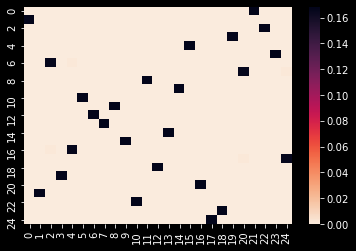

In [45]:
hmap(M * ot_mat_attached)

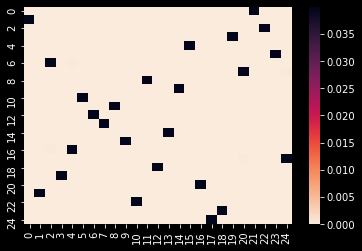

In [46]:
hmap(ot_mat_attached)

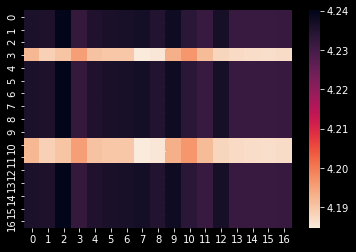

In [22]:
hmap(M)

In [13]:
torch_gwloss(constC, C1, C2, ot_mat_attached)

tensor(2.9989, grad_fn=<AddBackward0>)

In [14]:
torch_tensor_product(C1, C2, ot_mat_attached) * ot_mat_attached

tensor([[3.9562e-25, 3.9494e-25, 3.9502e-25, 3.9600e-25, 3.9491e-25, 3.9514e-25,
         3.9485e-25, 3.9475e-25, 3.9487e-25, 3.9522e-25, 3.1444e-23, 3.9785e-25,
         3.9458e-25, 1.7591e-01, 3.9495e-25, 3.9493e-25, 6.6449e-16],
        [3.9692e-25, 3.9633e-25, 3.9641e-25, 3.1449e-23, 3.9631e-25, 3.9651e-25,
         3.9624e-25, 3.9617e-25, 3.9629e-25, 5.2957e-20, 1.7682e-01, 1.7657e-05,
         3.9600e-25, 3.1448e-23, 5.9707e-16, 3.9634e-25, 3.9620e-25],
        [3.9689e-25, 3.9630e-25, 1.7666e-07, 6.6854e-16, 3.9632e-25, 1.2521e-11,
         3.9620e-25, 3.9924e-25, 3.1445e-23, 1.7672e-01, 3.1447e-23, 3.1448e-23,
         3.9598e-25, 3.9607e-25, 3.9630e-25, 6.6735e-22, 3.9618e-25],
        [3.9559e-25, 3.9487e-25, 3.9499e-25, 3.9599e-25, 3.9486e-25, 3.9510e-25,
         3.9478e-25, 1.7591e-05, 1.7595e-01, 3.1447e-23, 3.9539e-25, 3.9469e-25,
         3.9451e-25, 3.9461e-25, 3.9492e-25, 3.9490e-25, 3.9474e-25],
        [3.9716e-25, 3.9649e-25, 3.9663e-25, 3.9743e-25, 3.9649e-25, 3.9

# Dev new transport attention

In [26]:
common_dim = args.pc_hidden

k0 = nn.Linear(args.pc_hidden, args.n_hidden).to(device = args.device)
k1 = nn.Linear(args.n_hidden, common_dim).to(device = args.device)
q0 = nn.Linear(args.pc_hidden, args.n_hidden).to(device = args.device)
q1 = nn.Linear(args.n_hidden, common_dim).to(device = args.device)

In [27]:
common_dim = 200
eps = 1e-7
# k = torch.autograd.Variable(torch.randn(args.pc_hidden, common_dim))
# q = torch.autograd.Variable(torch.randn(args.pc_hidden, common_dim))

for idx, (stx, lex) in enumerate(X.scope):
    yhat = yhat_embedding[stx:stx+lex]
    x = x_embedding[stx:stx+lex]
#     M = 1/np.sqrt(common_dim) * torch.matmul(torch.matmul(x, k), torch.matmul(q.T, yhat.T))
    M = torch.matmul(k1(F.leaky_relu(k0(x))), q1(F.leaky_relu(q0(yhat))).T)
    attn = torch.softmax(M, dim = 1) + eps
    W = (attn / attn.sum(axis = 0))
   
    print (idx, lex)
    print (W.shape)
    print (W.sum(axis = 0))
    print (W.sum(axis = 1))
    break

0 17
torch.Size([17, 17])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


In [28]:
for i in k0.parameters():
    print (i)

Parameter containing:
tensor([[ 5.6572e-02,  1.7269e-02, -5.4802e-02,  ...,  7.5461e-03,
          2.9963e-02, -3.6632e-02],
        [ 6.2458e-02, -5.7978e-02, -1.9365e-02,  ...,  5.7244e-02,
          4.3100e-02,  5.0824e-02],
        [ 1.1562e-02, -5.6796e-02,  3.0116e-02,  ..., -4.8796e-03,
          7.0728e-02,  3.8857e-02],
        ...,
        [ 7.4211e-02,  2.8306e-02, -4.8592e-02,  ..., -1.0531e-02,
          6.4742e-02, -3.9617e-02],
        [-1.2268e-02,  5.4377e-02,  7.5516e-02,  ...,  3.1496e-02,
          2.6801e-02, -7.5632e-02],
        [ 7.7954e-02, -7.6709e-05,  1.7654e-02,  ..., -5.0347e-02,
          7.6149e-02,  6.5029e-02]], requires_grad=True)
Parameter containing:
tensor([ 0.0505,  0.0701,  0.0710, -0.0214,  0.0239,  0.0128,  0.0637, -0.0171,
        -0.0292, -0.0730,  0.0091, -0.0637, -0.0439,  0.0172,  0.0445, -0.0513,
        -0.0137,  0.0509,  0.0277,  0.0205,  0.0544, -0.0349, -0.0796, -0.0084,
        -0.0446, -0.0734, -0.0797,  0.0497,  0.0360,  0.0340,  0

In [47]:
q1(F.leaky_relu(q0(yhat))).shape

torch.Size([17, 200])

In [48]:
k1(F.leaky_relu(k0(x))).shape

torch.Size([17, 200])

In [49]:
torch.matmul(k1(F.leaky_relu(k0(x))), q1(F.leaky_relu(q0(yhat))).T)

tensor([[0.0286, 0.0779, 0.0858, 0.0302, 0.0597, 0.0630, 0.0734, 0.0594, 0.0589,
         0.0836, 0.0289, 0.0583, 0.0761, 0.0421, 0.0275, 0.0281, 0.0399],
        [0.0283, 0.0747, 0.0830, 0.0308, 0.0594, 0.0627, 0.0692, 0.0561, 0.0556,
         0.0801, 0.0267, 0.0564, 0.0729, 0.0405, 0.0257, 0.0262, 0.0383],
        [0.0244, 0.0711, 0.0807, 0.0272, 0.0565, 0.0597, 0.0665, 0.0532, 0.0520,
         0.0755, 0.0247, 0.0528, 0.0694, 0.0365, 0.0218, 0.0224, 0.0342],
        [0.0306, 0.0796, 0.0877, 0.0320, 0.0624, 0.0660, 0.0755, 0.0614, 0.0604,
         0.0852, 0.0306, 0.0602, 0.0782, 0.0443, 0.0294, 0.0299, 0.0420],
        [0.0263, 0.0745, 0.0829, 0.0289, 0.0576, 0.0607, 0.0690, 0.0556, 0.0551,
         0.0790, 0.0256, 0.0544, 0.0719, 0.0387, 0.0247, 0.0252, 0.0367],
        [0.0267, 0.0747, 0.0831, 0.0291, 0.0577, 0.0609, 0.0692, 0.0559, 0.0553,
         0.0792, 0.0258, 0.0546, 0.0721, 0.0389, 0.0247, 0.0253, 0.0368],
        [0.0271, 0.0724, 0.0816, 0.0296, 0.0576, 0.0608, 0.0668, 0.053

In [35]:
M.clamp(-1, 1)

tensor([[0.0286, 0.0779, 0.0858, 0.0302, 0.0597, 0.0630, 0.0734, 0.0594, 0.0589,
         0.0836, 0.0289, 0.0583, 0.0761, 0.0421, 0.0275, 0.0281, 0.0399],
        [0.0283, 0.0747, 0.0830, 0.0308, 0.0594, 0.0627, 0.0692, 0.0561, 0.0556,
         0.0801, 0.0267, 0.0564, 0.0729, 0.0405, 0.0257, 0.0262, 0.0383],
        [0.0244, 0.0711, 0.0807, 0.0272, 0.0565, 0.0597, 0.0665, 0.0532, 0.0520,
         0.0755, 0.0247, 0.0528, 0.0694, 0.0365, 0.0218, 0.0224, 0.0342],
        [0.0306, 0.0796, 0.0877, 0.0320, 0.0624, 0.0660, 0.0755, 0.0614, 0.0604,
         0.0852, 0.0306, 0.0602, 0.0782, 0.0443, 0.0294, 0.0299, 0.0420],
        [0.0263, 0.0745, 0.0829, 0.0289, 0.0576, 0.0607, 0.0690, 0.0556, 0.0551,
         0.0790, 0.0256, 0.0544, 0.0719, 0.0387, 0.0247, 0.0252, 0.0367],
        [0.0267, 0.0747, 0.0831, 0.0291, 0.0577, 0.0609, 0.0692, 0.0559, 0.0553,
         0.0792, 0.0258, 0.0546, 0.0721, 0.0389, 0.0247, 0.0253, 0.0368],
        [0.0271, 0.0724, 0.0816, 0.0296, 0.0576, 0.0608, 0.0668, 0.053

In [35]:
M.shape

torch.Size([25, 25])

In [37]:
M

tensor([[-4.8806e+01,  1.2745e+02,  8.5013e+01,  1.6420e+02,  1.8269e+01,
         -1.2526e+02, -6.7990e+01,  2.9985e+01, -6.0364e+01, -6.3572e+01,
          2.8890e+01, -6.3572e+01, -6.0364e+01,  2.9985e+01, -5.5506e+01,
         -1.0067e+02,  5.0763e+01,  2.1775e+02,  9.6130e+01,  1.8065e+02,
         -3.5103e+01,  2.1741e+02,  1.9373e+02,  1.2703e+02,  5.9381e+01],
        [-1.8349e+01,  9.2621e+01,  1.3784e+02,  1.6916e+02,  8.9967e+00,
         -1.7360e+02, -1.5138e+02, -4.8960e+01, -1.5916e+02, -1.6577e+02,
         -4.5353e+01, -1.6577e+02, -1.5916e+02, -4.8960e+01, -1.4277e+02,
         -1.3320e+02,  5.1016e+01,  9.9278e+01,  8.4654e+01,  1.2031e+02,
         -9.5534e+01,  1.5498e+02,  1.2172e+02,  5.0620e+01,  4.9736e+01],
        [ 1.3419e+01,  1.7614e+02,  2.3679e+02,  3.0860e+02,  2.7714e+01,
         -1.3887e+02, -7.2370e+01, -6.2119e+01, -8.8330e+01, -9.7444e+01,
         -6.0173e+01, -9.7444e+01, -8.8330e+01, -6.2119e+01, -6.4899e+01,
         -8.9064e+01,  7.9825e+01,  

In [48]:
Mdet_orig = M.detach().cpu().numpy().copy()
Mdet = M.detach().cpu().numpy().copy()
np.random.shuffle(Mdet)

In [50]:
Mdet

array([[-1.36550903e+02,  6.81647415e+01,  1.03288399e+02,
         7.67897720e+01,  3.60319481e+01, -1.35173340e+02,
        -1.08069221e+02,  3.83839455e+01, -8.44185638e+01,
        -8.56652298e+01,  4.37059669e+01, -8.56652298e+01,
        -8.44185638e+01,  3.83839607e+01, -8.79000778e+01,
        -9.98548050e+01,  4.25657501e+01,  2.22053623e+01,
         5.34014587e+01,  1.11797241e+02,  8.24223709e+01,
         2.01263702e+02,  6.49279480e+01,  7.15621567e+01,
         8.77687454e+01],
       [-1.41745499e+02,  6.95025024e+01,  1.02559906e+02,
         7.86224289e+01,  3.32511063e+01, -1.30562500e+02,
        -1.09084831e+02,  3.38087959e+01, -8.56264267e+01,
        -8.72580566e+01,  3.84175034e+01, -8.72580566e+01,
        -8.56264267e+01,  3.38088036e+01, -8.87138443e+01,
        -9.84396439e+01,  4.13976135e+01,  2.88886242e+01,
         5.95451431e+01,  1.15779877e+02,  8.77940063e+01,
         2.05081360e+02,  6.82530594e+01,  7.96451645e+01,
         8.66283646e+01],
    

In [52]:
Mdet_orig

array([[-1.36550903e+02,  6.81647415e+01,  1.03288399e+02,
         7.67897720e+01,  3.60319481e+01, -1.35173340e+02,
        -1.08069221e+02,  3.83839455e+01, -8.44185638e+01,
        -8.56652298e+01,  4.37059669e+01, -8.56652298e+01,
        -8.44185638e+01,  3.83839607e+01, -8.79000778e+01,
        -9.98548050e+01,  4.25657501e+01,  2.22053623e+01,
         5.34014587e+01,  1.11797241e+02,  8.24223709e+01,
         2.01263702e+02,  6.49279480e+01,  7.15621567e+01,
         8.77687454e+01],
       [-5.45599861e+01,  1.00158745e+02,  1.05964836e+02,
        -2.31788368e+01,  1.03137474e+02,  1.13762985e+02,
         4.22908745e+01,  1.18958099e+02,  5.50460625e+01,
         5.07430649e+01,  1.22109154e+02,  5.07430649e+01,
         5.50460625e+01,  1.18958084e+02,  3.96638756e+01,
         1.58115173e+02,  1.54708847e+02, -8.90717983e+00,
         1.79497879e+02,  1.27680420e+02,  2.79696488e+00,
         7.15046005e+01,  1.03312851e+02,  7.64186859e+01,
         4.51117783e+01],
    

In [53]:
M[torch.randperm(M.size()[0])].detach().clone()

tensor([[-1.0118e+02, -1.5469e+01, -5.3189e+01, -4.8951e+01, -1.4664e+02,
         -3.8039e+02, -2.6164e+02, -8.3566e+01, -2.3841e+02, -2.3828e+02,
         -9.4402e+01, -2.3828e+02, -2.3841e+02, -8.3566e+01, -2.4270e+02,
         -3.4588e+02, -8.8649e+01,  7.1412e+01, -6.5000e+01, -1.1127e+02,
          1.5097e+01,  2.0600e+02,  1.3323e+01,  1.3850e+01,  1.6531e+02],
        [-5.4560e+01,  1.0016e+02,  1.0596e+02, -2.3179e+01,  1.0314e+02,
          1.1376e+02,  4.2291e+01,  1.1896e+02,  5.5046e+01,  5.0743e+01,
          1.2211e+02,  5.0743e+01,  5.5046e+01,  1.1896e+02,  3.9664e+01,
          1.5812e+02,  1.5471e+02, -8.9072e+00,  1.7950e+02,  1.2768e+02,
          2.7970e+00,  7.1505e+01,  1.0331e+02,  7.6419e+01,  4.5112e+01],
        [-1.4175e+02,  6.9503e+01,  1.0256e+02,  7.8622e+01,  3.3251e+01,
         -1.3056e+02, -1.0908e+02,  3.3809e+01, -8.5626e+01, -8.7258e+01,
          3.8418e+01, -8.7258e+01, -8.5626e+01,  3.3809e+01, -8.8714e+01,
         -9.8440e+01,  4.1398e+01,  

In [15]:
attn.T / attn.sum(axis = 0)

tensor([[1.8529e-02, 2.5068e-07, 3.9987e-02, 4.0000e-02, 4.0000e-02, 4.0000e-02,
         4.0000e-02, 3.9179e-02, 4.0000e-02, 4.0000e-02, 1.8434e-07, 4.0000e-02,
         4.0000e-02, 3.9179e-02, 4.0000e-02, 1.0009e-07, 4.0000e-02, 9.9163e-08,
         4.0000e-02, 9.5670e-09, 2.4148e-08, 4.0000e-02, 1.0542e-06, 1.7043e-06,
         2.1951e-08],
        [1.8529e-02, 2.5068e-07, 3.9987e-02, 4.0000e-02, 4.0000e-02, 4.0000e-02,
         4.0000e-02, 3.9179e-02, 4.0000e-02, 4.0000e-02, 1.8434e-07, 4.0000e-02,
         4.0000e-02, 3.9179e-02, 4.0000e-02, 1.0009e-07, 4.0000e-02, 9.9163e-08,
         4.0000e-02, 9.5670e-09, 2.4148e-08, 1.5957e+05, 3.5173e-08, 1.7043e-06,
         2.1951e-08],
        [1.8529e-02, 2.5068e-07, 4.0323e-02, 4.0000e-02, 4.0000e-02, 4.0000e-02,
         4.0000e-02, 3.9179e-02, 4.0000e-02, 4.0000e-02, 1.8434e-07, 4.0000e-02,
         4.0000e-02, 3.9179e-02, 4.0000e-02, 1.0009e-07, 4.0000e-02, 9.9163e-08,
         4.0000e-02, 9.5670e-09, 2.4148e-08, 4.0000e-02, 3.5173e-

In [16]:
(attn / attn.sum(axis = 0)

SyntaxError: unexpected EOF while parsing (<ipython-input-16-bfc19aa26183>, line 1)

In [17]:
attn.sum(axis = 0)


tensor([5.3970e-06, 3.9892e-01, 2.5008e-06, 2.5000e-06, 2.5000e-06, 2.5000e-06,
        2.5000e-06, 2.5524e-06, 2.5000e-06, 2.5000e-06, 5.4248e-01, 2.5000e-06,
        2.5000e-06, 2.5524e-06, 2.5000e-06, 9.9907e-01, 2.5000e-06, 1.0084e+00,
        2.5000e-06, 1.0453e+01, 4.1411e+00, 2.5000e-06, 2.8431e+00, 5.8674e-02,
        4.5557e+00], grad_fn=<SumBackward1>)

In [20]:
torch.nn.ModuleList([None])

ModuleList(
  (0): None
)